In [43]:
!pip install piqa

In [44]:
import argparse
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from __future__ import print_function
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.optim import Adam
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from piqa import SSIM
from sklearn.metrics import accuracy_score

In [45]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
  
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
  
# DataLoader is used to load the dataset 
# for training
data_loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 64,
                                     shuffle = True)

In [46]:
total_size = len(data_loader)
print(total_size)

938


In [47]:
cuda = torch.cuda.is_available()
seed = 10

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
n_classes = 10

# Latent Dimension feature tensor shape
z_dim = 2

# image dimension
X_dim = 784

train_batch_size = 64

# No of intermediate nodes
N = 1000
# No of epochs
epochs = 100

In [48]:
# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p = 0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p = 0.2, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)

        return xgauss

In [49]:
# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p = 0.2, training = self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p = 0.2, training = self.training)
        x = self.lin3(x)
        return F.sigmoid(x)

In [50]:
# Discriminator
class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

In [51]:
# initialising lists to store losses and accuracies
discriminator_loss_bce = []
reconstruction_loss_bce = []
g_loss_bce = []
discriminator_loss_ssim = []
reconstruction_loss_ssim = []
g_loss_ssim = []
discriminator_loss_mse = []
reconstruction_loss_mse = []
g_loss_mse = []
training_accuracy_mse = []
training_accuracy_bce = []
training_accuracy_ssim = []

In [52]:
def report_loss(epoch, D_loss_gauss, G_loss, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; D_loss_gauss: {:.4}; recon_loss: {:.4}'.format(epoch,D_loss_gauss.data,recon_loss.data))

In [53]:
####################
# Train procedure
def train(P, Q, D_gauss, P_decoder, Q_encoder, Q_generator, D_gauss_solver, data_loader, loss_function):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()
    D_gauss.train()
    final_recon_loss=0
    final_D_loss=0
    final_G_loss=0

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    for X, target in data_loader:

        # Load batch and normalize samples to be between 0 and 1
        X = X * 0.3081 + 0.1307
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)

        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        #######################
        # Reconstruction phase
        #######################
        z_sample = Q(X)
        X_sample = P(z_sample)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        acc = cos(X, X_sample)

        if loss_function == 'BCE':
          recon_loss = F.binary_cross_entropy(X_sample + TINY, X.resize_(train_batch_size, X_dim) + TINY)

        if loss_function == 'MSE':
          mse_loss = nn.MSELoss()
          recon_loss = mse_loss(X_sample, X.resize_(train_batch_size, X_dim))

        if loss_function == 'SSIM':
          ssim_loss = SSIM(n_channels = 64,value_range = 2).cuda()
          recon_loss = 1 - ssim_loss(X_sample.view(1,train_batch_size,X_dim),X.resize(1,train_batch_size, X_dim))
          
        final_recon_loss += recon_loss.data

        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        #######################
        # Regularization phase
        #######################
        # Discriminator
        Q.eval()
        z_real_gauss = Variable(torch.randn(train_batch_size, z_dim) * 5.)
        if cuda:
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)

        D_real_gauss = D_gauss(z_real_gauss)
        D_fake_gauss = D_gauss(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))
        final_D_loss += D_loss.data

        D_loss.backward()
        D_gauss_solver.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        # Generator
        Q.train()
        z_fake_gauss = Q(X)

        D_fake_gauss = D_gauss(z_fake_gauss)
        G_loss = -torch.mean(torch.log(D_fake_gauss + TINY))
        final_G_loss += G_loss.data

        G_loss.backward()
        Q_generator.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

    if loss_function == 'BCE':
      training_accuracy_bce.append(acc.mean())
    if loss_function == 'MSE':
      training_accuracy_mse.append(acc.mean())
    if loss_function == 'SSIM':
      training_accuracy_ssim.append(acc.mean())

    return final_D_loss/total_size, final_G_loss/total_size, final_recon_loss/total_size

In [54]:
def generate_model(train_loader,loss_function):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
        D_gauss = D_net_gauss().cuda()
    else:
        Q = Q_net()
        P = P_net()
        D_gauss = D_net_gauss()

    # Set learning rates
    gen_lr = 0.0001
    reg_lr = 0.00005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
    D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)

    for epoch in tqdm(range(epochs)):
        if loss_function == 'BCE':
          D_loss_gauss, G_loss, recon_loss,acc = train(P, Q, D_gauss, P_decoder, Q_encoder,Q_generator,D_gauss_solver,train_loader,loss_function)
          discriminator_loss_bce.append(D_loss_gauss.data)
          reconstruction_loss_bce.append(recon_loss.data)
          g_loss_bce.append(G_loss.data)
          report_loss(epoch, D_loss_gauss, G_loss, recon_loss)
        

        if loss_function == 'MSE':
          D_loss_gauss, G_loss, recon_loss = train(P, Q, D_gauss, P_decoder, Q_encoder,Q_generator,D_gauss_solver,train_loader,loss_function)
          discriminator_loss_mse.append(D_loss_gauss.data)
          reconstruction_loss_mse.append(recon_loss.data)
          g_loss_mse.append(G_loss.data)
          report_loss(epoch, D_loss_gauss, G_loss, recon_loss)

        if loss_function == 'SSIM':
          D_loss_gauss, G_loss, recon_loss = train(P, Q, D_gauss, P_decoder, Q_encoder,Q_generator,D_gauss_solver,train_loader,loss_function)
          discriminator_loss_ssim.append(D_loss_gauss.data)
          reconstruction_loss_ssim.append(recon_loss.data)
          g_loss_ssim.append(G_loss.data)
          report_loss(epoch, D_loss_gauss, G_loss, recon_loss)

    return Q, P

In [55]:
Q_bce, P_bce = generate_model(data_loader,'BCE')


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 100/100 [34:47<00:00, 20.88s/it]Epoch-99; D_loss_gauss: 1.352; recon_loss: 0.4423



In [56]:
Q_mse, P_mse = generate_model(data_loader,'MSE')


 0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 100/100 [31:22<00:00, 18.82s/it]Epoch-99; D_loss_gauss: 1.377; recon_loss: 0.004229



In [57]:
Q_ssim, P_ssim = generate_model(data_loader,'SSIM')



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Epoch-0; D_loss_gauss: 333.7; G_loss: 2.065e+03; recon_loss: 233.2
Epoch-1; D_loss_gauss: 549.0; G_loss: 1.976e+03; recon_loss: 180.7
Epoch-2; D_loss_gauss: 678.3; G_loss: 1.529e+03; recon_loss: 169.6
Epoch-3; D_loss_gauss: 768.2; G_loss: 1.336e+03; recon_loss: 164.5
Epoch-4; D_loss_gauss: 847.5; G_loss: 1.208e+03; recon_loss: 161.0
Epoch-5; D_loss_gauss: 911.2; G_loss: 1.121e+03; recon_loss: 158.7
Epoch-6; D_loss_gauss: 974.2; G_loss: 1.038e+03; recon_loss: 157.0
Epoch-7; D_loss_gauss: 1.026e+03; G_loss: 964.0; recon_loss: 155.5
Epoch-8; D_loss_gauss: 1.077e+03; G_loss: 903.3; recon_loss: 154.5
Epoch-9;

In [58]:
def get_numpy(discriminator_loss,reconstruction_loss):
    dloss = []
    discriminator_loss = discriminator_loss
    for x in discriminator_loss:
      dloss.append(x.cpu().detach().numpy())

    rloss = []
    reconstruction_loss = reconstruction_loss
    for x in reconstruction_loss:
      rloss.append(x.cpu().detach().numpy())
    return dloss,rloss

In [59]:
def get_three_loss_plot():
    dloss_bce,rloss_bce = get_numpy(discriminator_loss_bce,reconstruction_loss_bce)
    dloss_mse,rloss_mse = get_numpy(discriminator_loss_mse,reconstruction_loss_mse)
    dloss_ssim,rloss_ssim = get_numpy(discriminator_loss_ssim,reconstruction_loss_ssim)
    y = []
    for val in range(0,epochs + 1):
        y.append(val)

    # # # plotting the line 1 points
    plt.plot(y, dloss_bce, label = "Discriminator loss")
    plt.plot(y, rloss_bce, label = "Reconstruction loss")
    plt.plot(y, dloss_mse, label = "Discriminator loss")
    plt.plot(y, rloss_mse, label = "Reconstruction loss")
    plt.plot(y, dloss_ssim, label = "Discriminator loss")
    plt.plot(y, rloss_ssim, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

In [60]:
def get_three_accuracy_plot():
    tloss_bce = []
    for x in training_accuracy_bce:
      tloss_bce.append(x.cpu().detach().numpy())
    tloss_mse = []
    for x in training_accuracy_mse:
      tloss_mse.append(x.cpu().detach().numpy())
    tloss_ssim = []
    for x in training_accuracy_ssim:
      tloss_ssim.append(x.cpu().detach().numpy())
    y = []
    for val in range(0,epochs + 1):
        y.append(val)

    # # # plotting the line 1 points
    plt.plot(y, tloss_bce, label = "Accuracy BCE")
    plt.plot(y, tloss_mse, label = "Accuracy MSE")
    plt.plot(y, tloss_ssim, label = "Accuracy SSIM")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

In [61]:
def get_bce_loss_plot():
    dloss_bce,rloss_bce = get_numpy(discriminator_loss_bce,reconstruction_loss_bce)
    y = [i for i in range(0,epochs + 1)]
    # # # plotting the line 1 points
    plt.plot(y, dloss_bce, label = "Discriminator loss")
    plt.plot(y, rloss_bce, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    plt.grid(True)
    # function to show the plot
    plt.show()

In [62]:
def get_bce_reconstruction_loss_plot():
    dloss_bce,rloss_bce = get_numpy(discriminator_loss_bce,reconstruction_loss_bce)
    y = [i for i in range(0,epochs + 1)]
    # # # plotting the line 1 points
    plt.plot(y, rloss_bce, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    plt.grid(True)
    # function to show the plot
    plt.show()

In [63]:
def get_mse_loss_plot():
    dloss_mse,rloss_mse = get_numpy(discriminator_loss_mse,reconstruction_loss_mse)
    y = [i for i in range(0,epochs + 1)]
    # # # plotting the line 1 points
    plt.plot(y, dloss_mse, label = "Discriminator loss")
    plt.plot(y, rloss_mse, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    plt.grid(True)
    # function to show the plot
    plt.show()

In [64]:
def get_mse_reconstruction_loss_plot():
    dloss_mse,rloss_mse = get_numpy(discriminator_loss_mse,reconstruction_loss_mse)
    y = [i for i in range(0,epochs + 1)]
    # # # plotting the line 1 points
    plt.plot(y, rloss_mse, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    plt.grid(True)
    # function to show the plot
    plt.show()

In [65]:
def get_ssim_loss_plot():
    dloss_ssim,rloss_ssim = get_numpy(discriminator_loss_ssim,reconstruction_loss_ssim)
    y = []
    for val in range(0,epochs):
        y.append(val)

    # # # plotting the line 1 points
    plt.plot(y, dloss_ssim, label = "Discriminator loss")
    plt.plot(y, rloss_ssim, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

In [66]:
def get_ssim_reconstruction_loss_plot():
    dloss_ssim,rloss_ssim = get_numpy(discriminator_loss_ssim,reconstruction_loss_ssim)
    y = [i for i in range(0,epochs + 1)]
    # # # plotting the line 1 points
    plt.plot(y, rloss_ssim, label = "Reconstruction loss")
    
    # naming the x axis
    plt.xlabel('Epoch')
    # naming the y axis
    plt.ylabel('Loss')
    # giving a title to my graph
    plt.title('Losses')
    
    # show a legend on the plot
    plt.legend()
    
    plt.grid(True)
    # function to show the plot
    plt.show()

Q1: Plot a sample of generated image and real image for all 0-9 digits

We plotted the images for the entire first_batch using SSIM as a loss function. This includes all the digits from 0-9

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


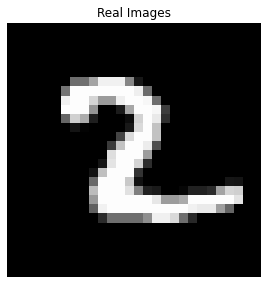

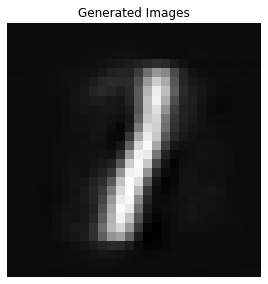

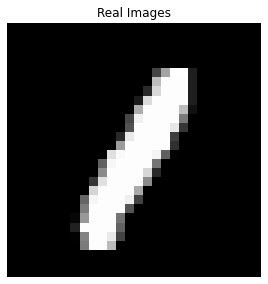

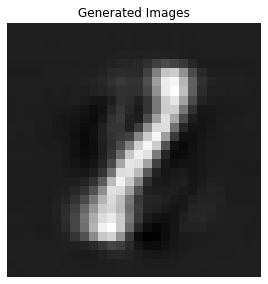

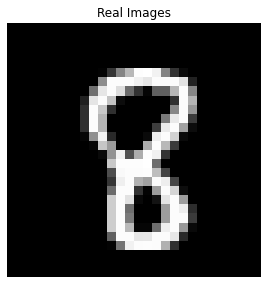

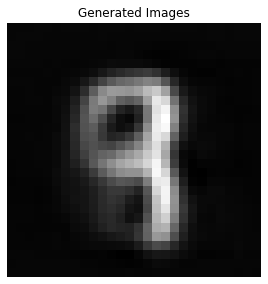

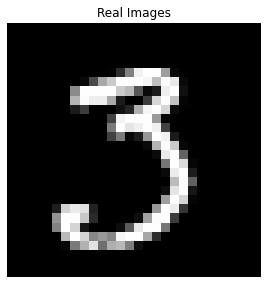

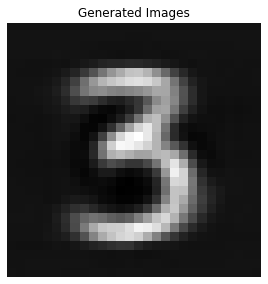

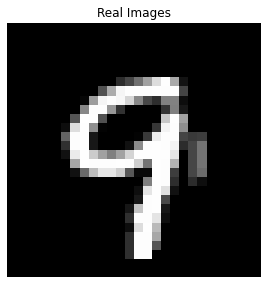

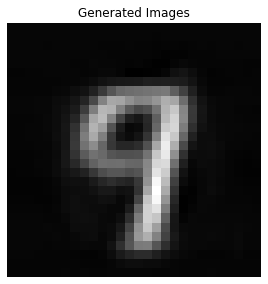

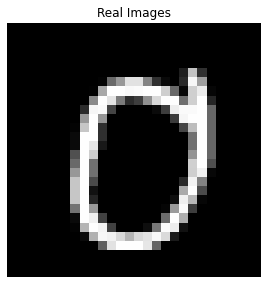

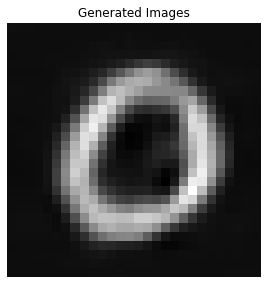

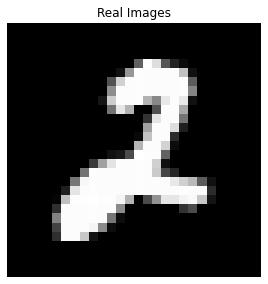

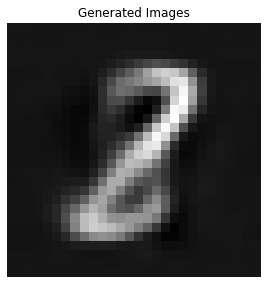

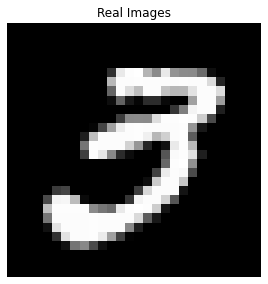

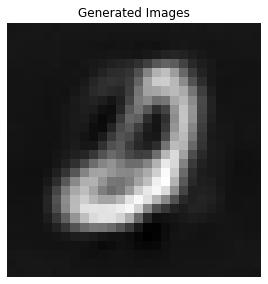

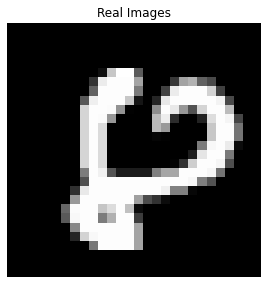

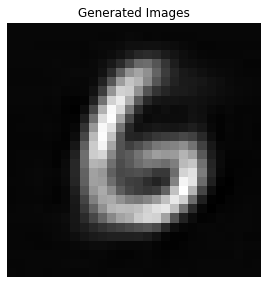

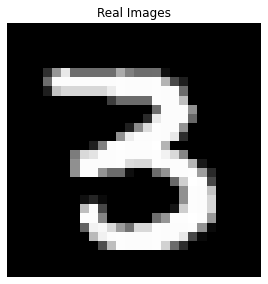

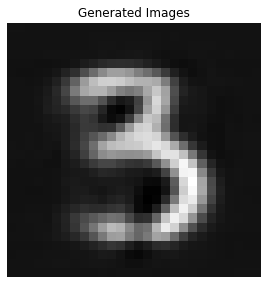

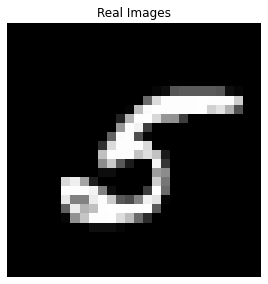

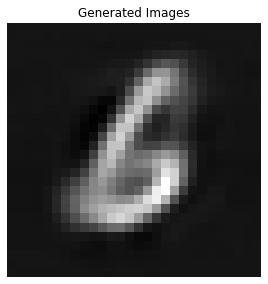

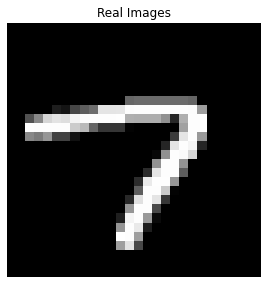

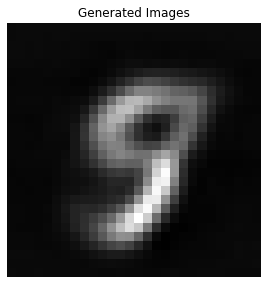

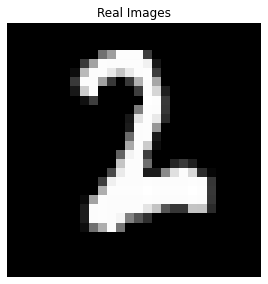

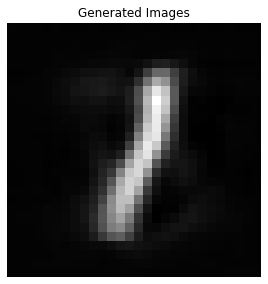

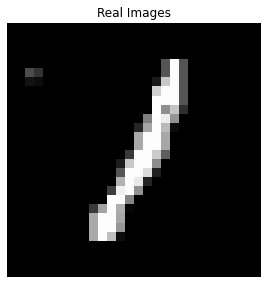

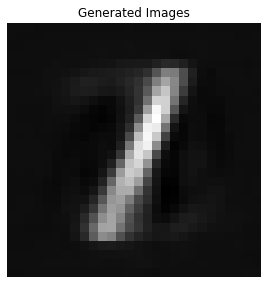

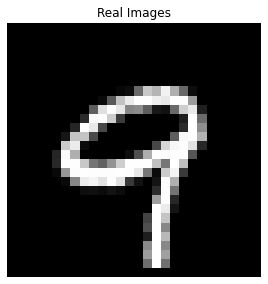

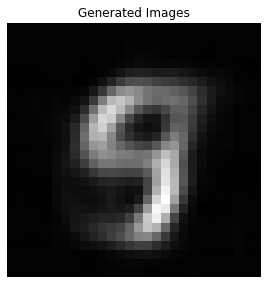

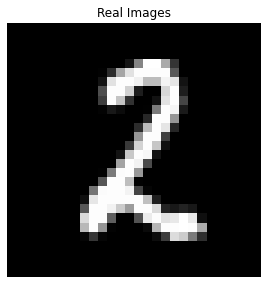

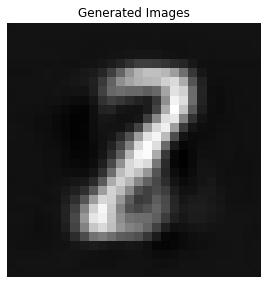

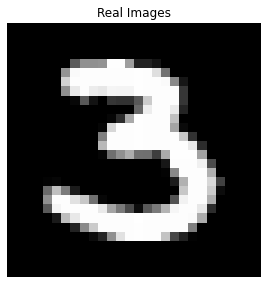

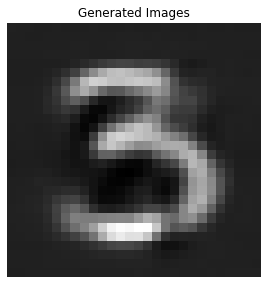

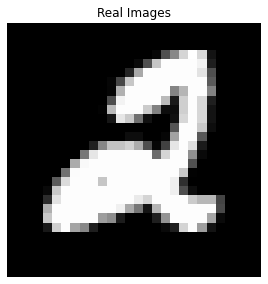

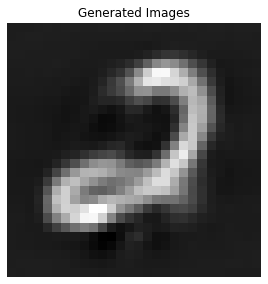

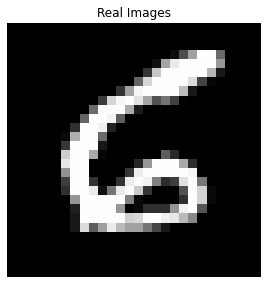

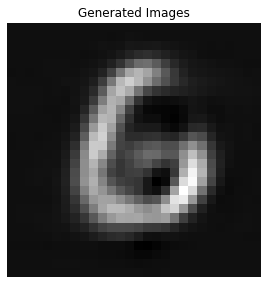

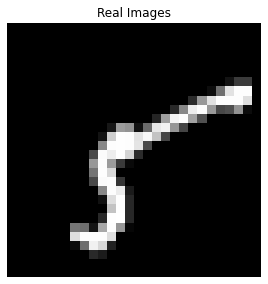

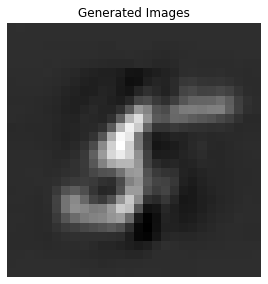

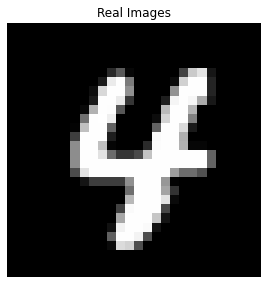

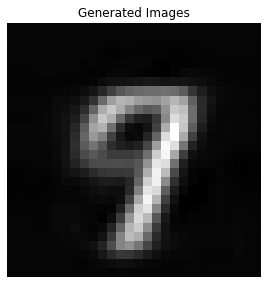

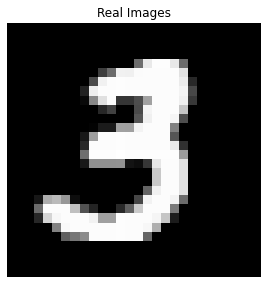

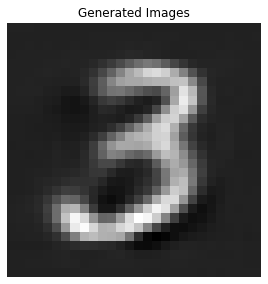

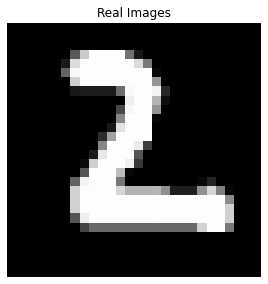

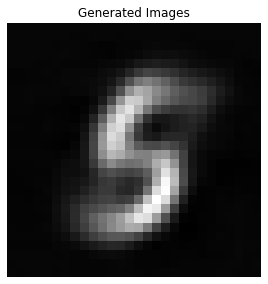

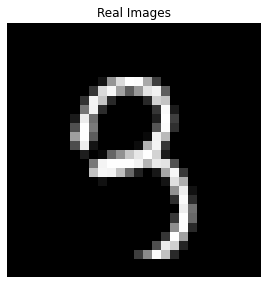

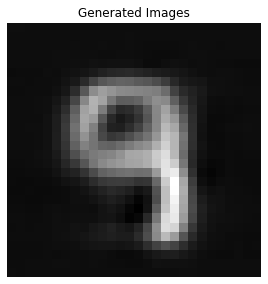

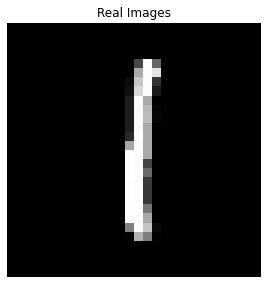

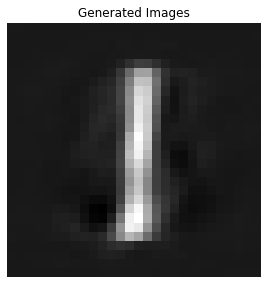

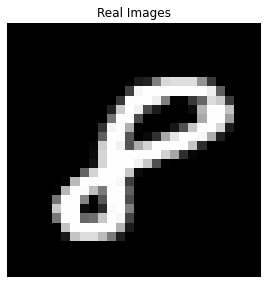

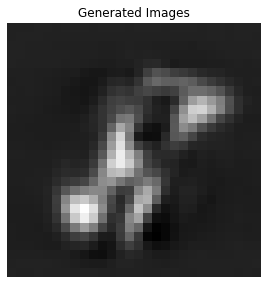

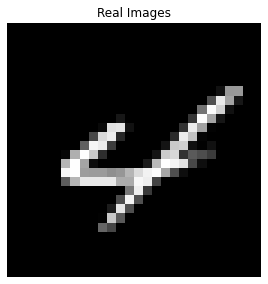

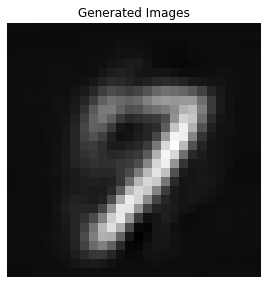

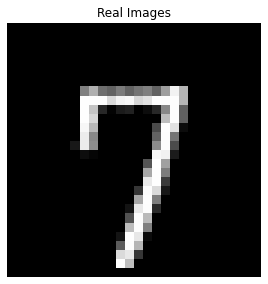

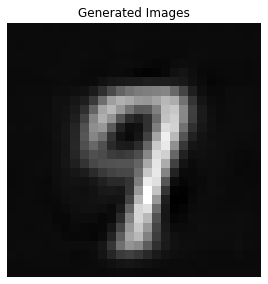

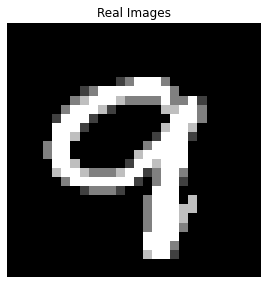

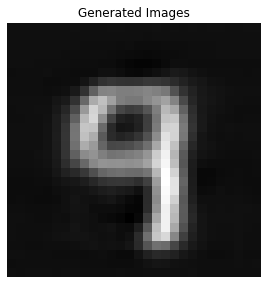

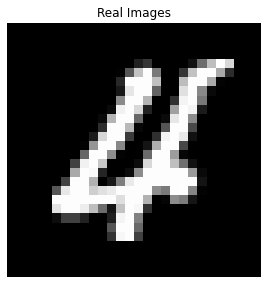

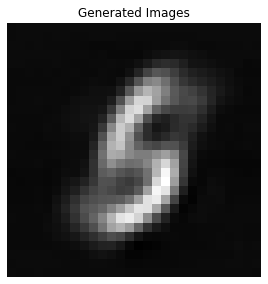

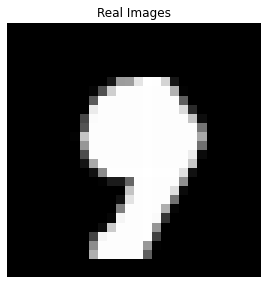

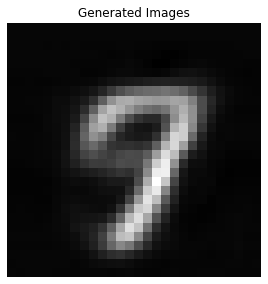

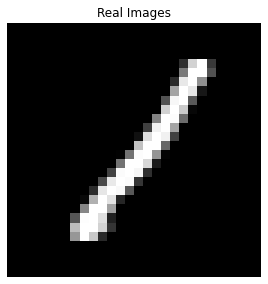

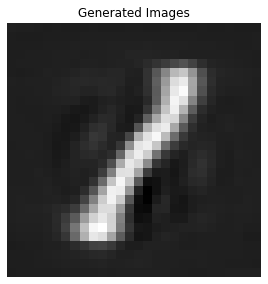

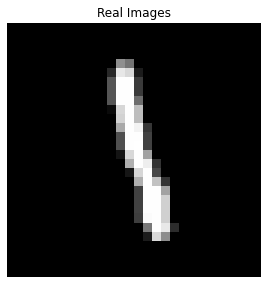

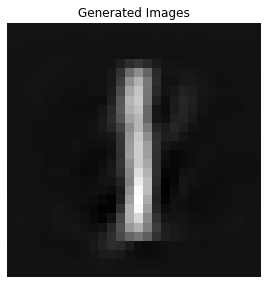

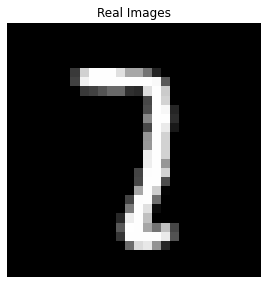

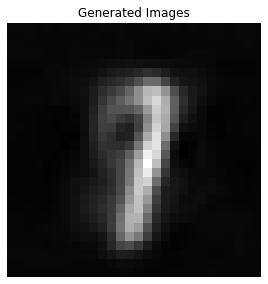

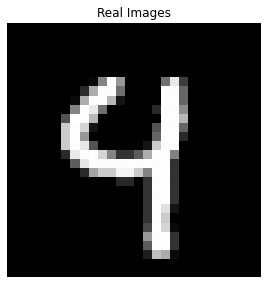

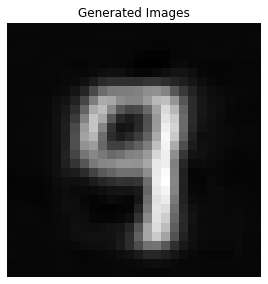

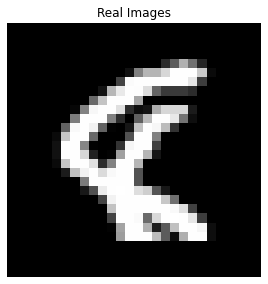

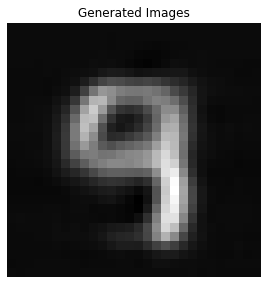

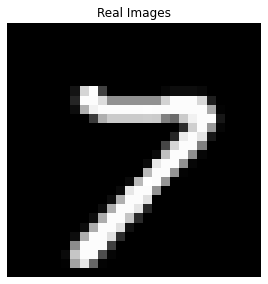

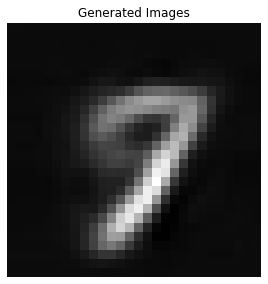

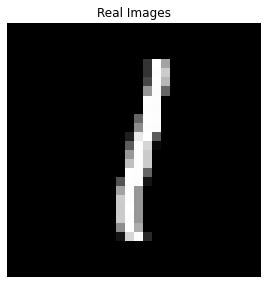

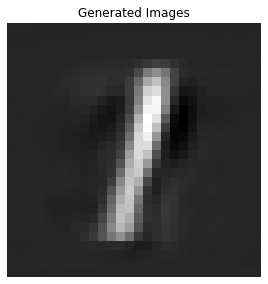

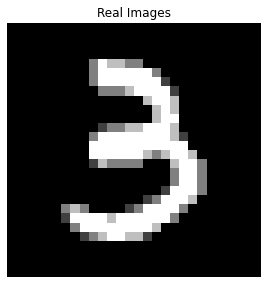

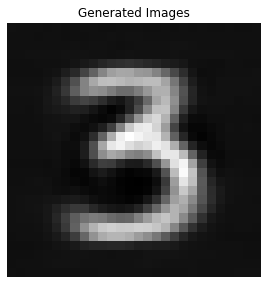

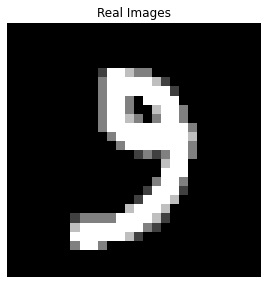

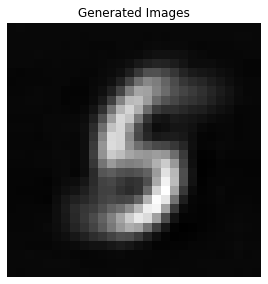

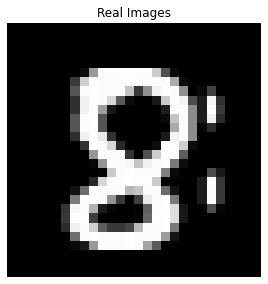

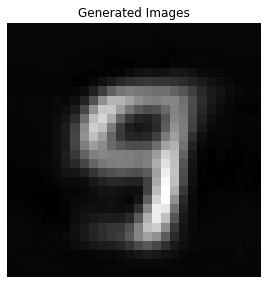

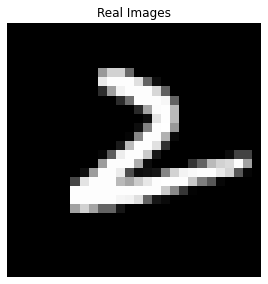

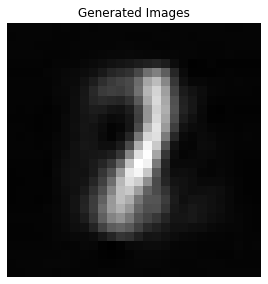

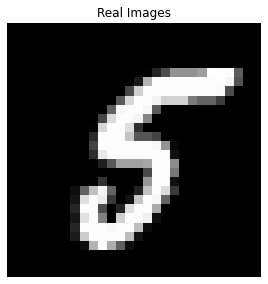

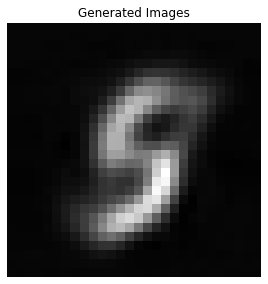

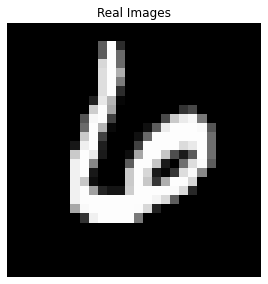

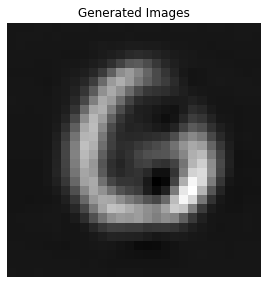

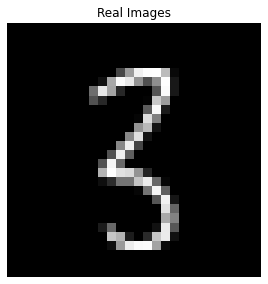

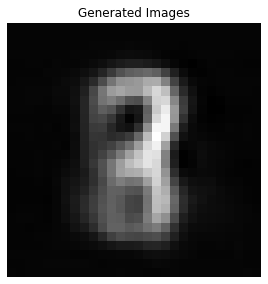

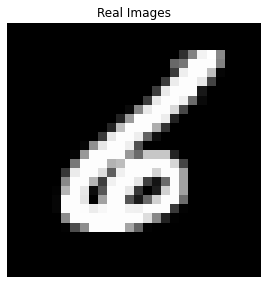

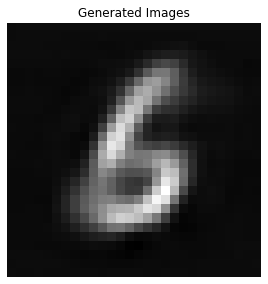

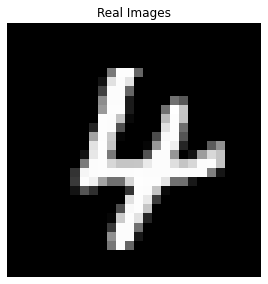

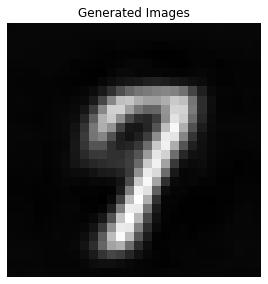

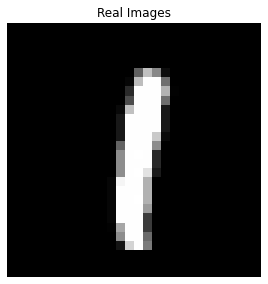

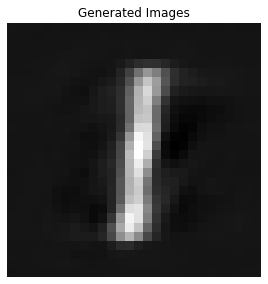

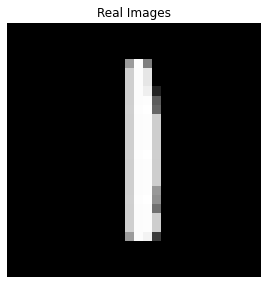

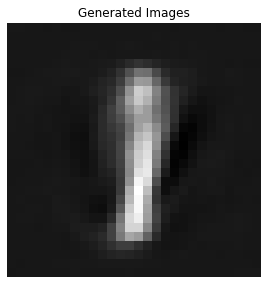

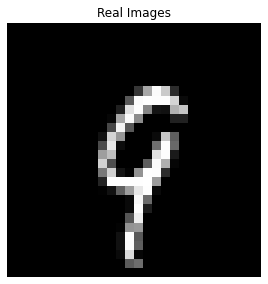

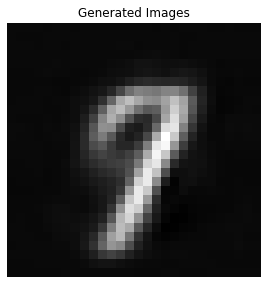

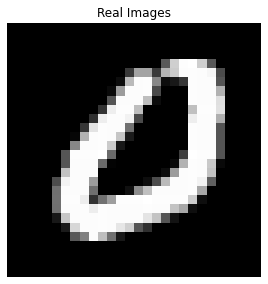

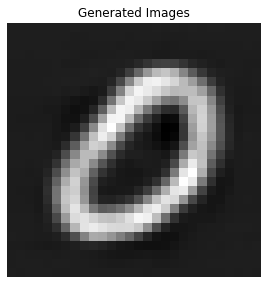

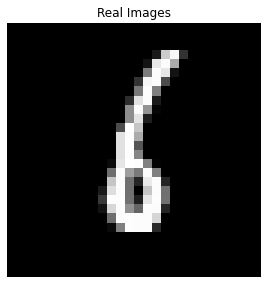

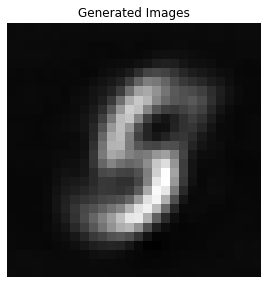

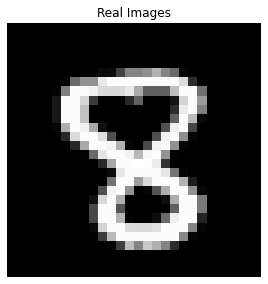

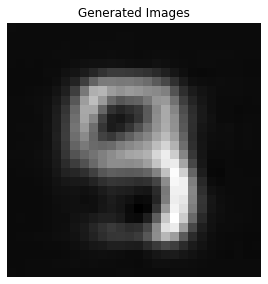

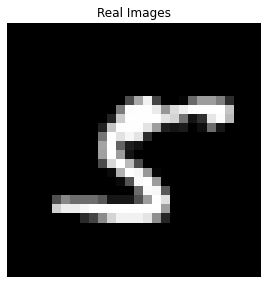

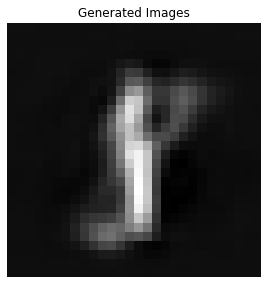

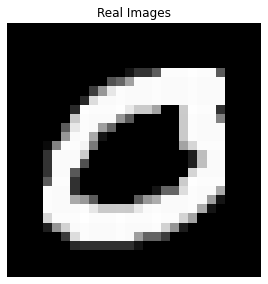

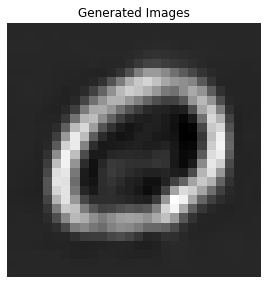

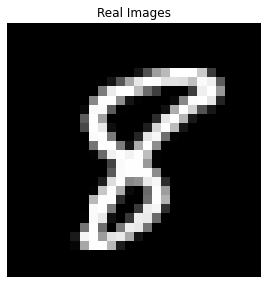

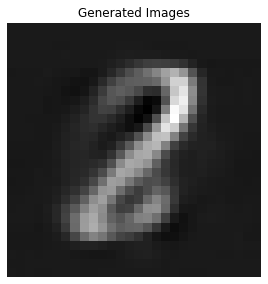

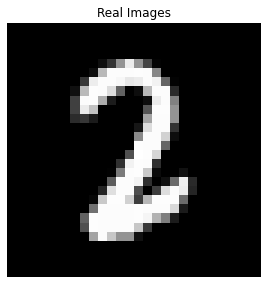

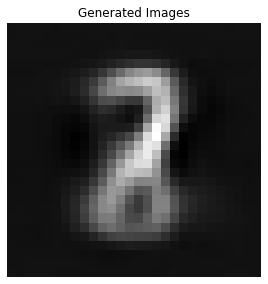

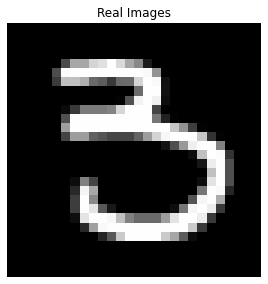

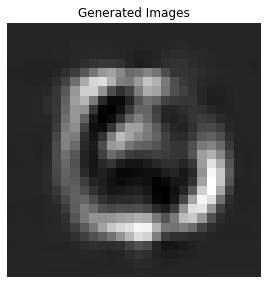

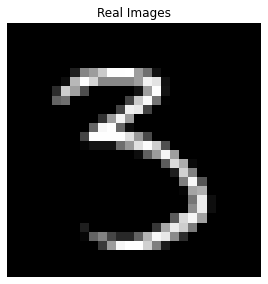

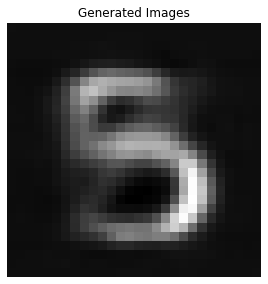

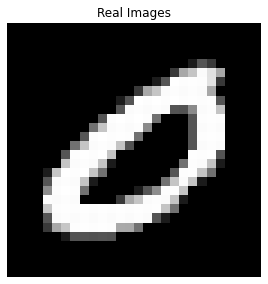

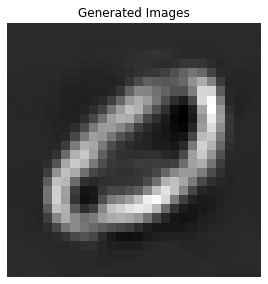

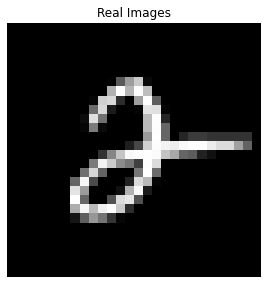

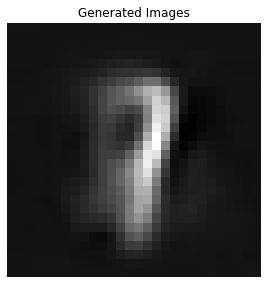

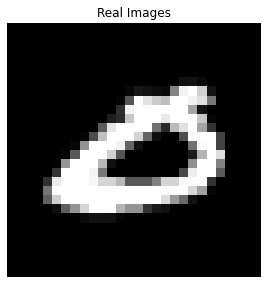

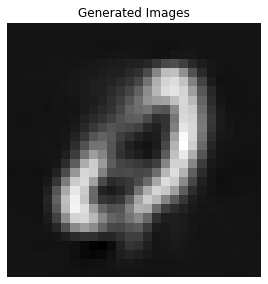

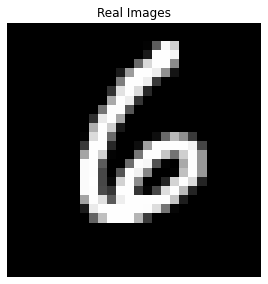

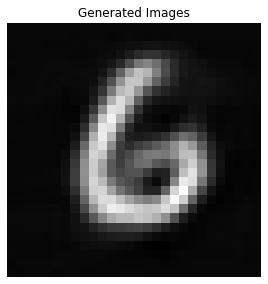

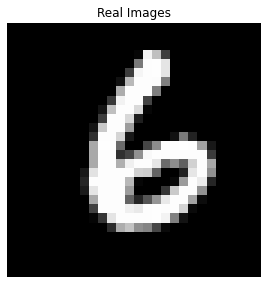

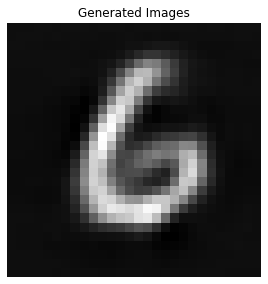

In [67]:
first_batch = next(iter(data_loader))
for i in range(64):
  
  # Load batch and normalize samples to be between 0 and 1
  X = first_batch[0][i]
  target = first_batch[1][i]
  X = X * 0.3081 + 0.1307
  X.resize_(train_batch_size, X_dim)
  X, target = Variable(X), Variable(target)
  if cuda:
      X, target = X.cuda(), target.cuda()
  # Grab a batch of real images from the dataloader
  real_batch = X.view(64,28,28)


  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(
    np.transpose(
    vutils.make_grid(
        real_batch[0].cuda()[:64], padding=5, normalize=True
    ).cpu(),
    (1, 2, 0),
        )
  )
  # Reconstruction phase

  z_sample = Q_ssim(X)
  X_sample = P_ssim(z_sample)
  Z =  X_sample.view(64,28,28)
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.axis("off")
  plt.title("Generated Images")
  plt.imshow(
    np.transpose(
    vutils.make_grid(
        Z[0].cuda()[:64], padding=5, normalize=True
    ).cpu(),
    (1, 2, 0),
        )
  )

Q2: Plot the reconstruction loss and discriminator loss over all the epochs in one graph. Comments on the nature/trend of the graphs produced.

PLOTS FOR BCE LOSS

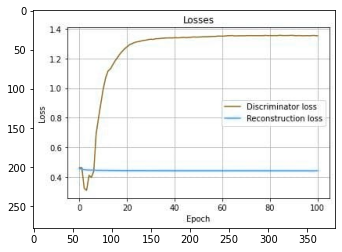

In [68]:
get_bce_loss_plot()

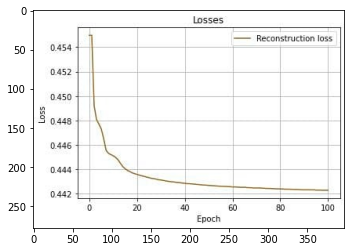

In [69]:
get_bce_reconstruction_loss_plot()

PLOTS FOR MSE LOSS

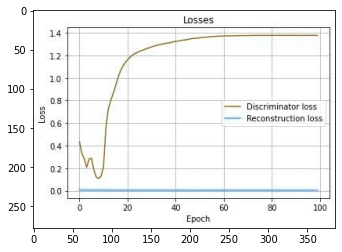

In [70]:
get_mse_loss_plot()

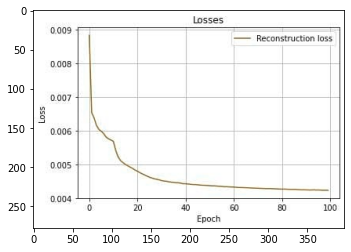

In [72]:
get_mse_reconstruction_loss_plot()

PLOTS FOR SSIM LOSS

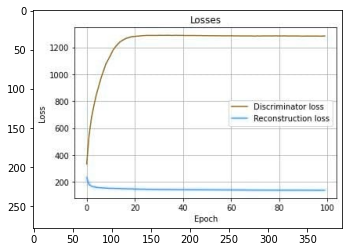

In [73]:
get_ssim_loss_plot()

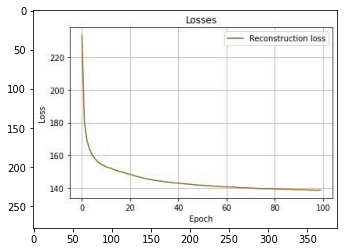

In [74]:
get_ssim_reconstruction_loss_plot()

Q3: Write the entire training process of the vanilla adversarial autoencoder in brief and concise 3-5 step algorithm.

1. The images in the dataset are supplied into an encoder, which generates a latent representation, which is then fed into a decoder, which generates the produced image.
2. The preceding step's latent representation is treated to a discriminator, which causes it to follow the provided gaussian distribution.
3. The gradients of the discriminator and reconstruction losses are utilised to update the encoder weights. The generator loss is used to update the decoder weights.
4. Finally the accuracy of discriminator becomes 50%.

Q4. Plot the training accuracy and loss values for all the 3 loss functions as 2 separate plots.


PLOT FOR THREE LOSS FUNCTIONS

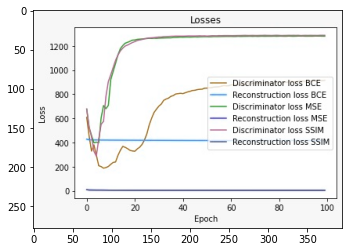

In [75]:
get_three_loss_plot()

PLOT FOR RECONSTRUCTION ACCURACIES 

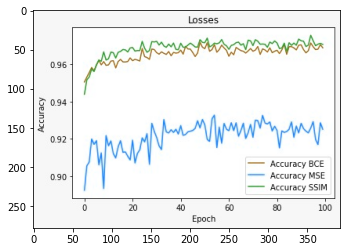

In [76]:
# plotting accuracies for 3 loss functions
get_three_accuracy_plot()

Q5: Based on the plots in Q4, provide your comments on which of the suggested loss functions is best for the current task and why?

We presume that SSIM is a superior loss function than other loss functions since it's accuarcy is better